Задание 1.
Задание: обучите три классификатора:

1) на токенах с высокой частотой

2) на токенах со средней частотой

3) на токенах с низкой частотой

Сравните полученные результаты, оцените какие токены наиболее важные для классификации.

Задание 2.
найти фичи с наибольшей значимостью, и вывести их

Задание 3.
1) сравнить count/tf-idf/hashing векторайзеры/полносвязанную сетку (построить classification_report)

2) подобрать оптимальный размер для hashing векторайзера

3) убедиться что для сетки нет переобучения

In [1]:
import pandas as pd
import numpy as np
import re
import os

from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk import ngrams

from collections import Counter
from nltk.tokenize import word_tokenize



import warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning)

Функция удаления стов начинающихся с @

In [2]:
def funk_del(input_txt):
    pattern = "@[\w]*"
    if re.findall(pattern, input_txt):
        return re.sub(pattern, ' ', input_txt)
    else:
        return re.sub(pattern, ' ', input_txt)


In [3]:
# считываем данные и заполняем общий датасет
positive = pd.read_csv('positive.csv', sep=';', usecols=[3], names=['text'])
positive['label'] = ['positive'] * len(positive)
negative = pd.read_csv('negative.csv', sep=';', usecols=[3], names=['text'])
negative['label'] = ['negative'] * len(negative)
df = positive.append(negative)

In [4]:
df.head()

,text,label
0,"@first_timee хоть я и школота, но поверь, у на...",positive
1,"Да, все-таки он немного похож на него. Но мой ...",positive
2,RT @KatiaCheh: Ну ты идиотка) я испугалась за ...,positive
3,"RT @digger2912: ""Кто то в углу сидит и погибае...",positive
4,@irina_dyshkant Вот что значит страшилка :D\nН...,positive


In [5]:
df.tail()

,text,label
111918,Но не каждый хочет что то исправлять:( http://...,negative
111919,скучаю так :-( только @taaannyaaa вправляет мо...,negative
111920,"Вот и в школу, в говно это идти уже надо(",negative
111921,"RT @_Them__: @LisaBeroud Тауриэль, не грусти :...",negative
111922,Такси везет меня на работу. Раздумываю приплат...,negative


# Baseline: классификация необработанных n-грамм

In [6]:
x_train, x_test, y_train, y_test = train_test_split(df.text, df.label)

In [7]:
vec = CountVectorizer(ngram_range=(1, 1))
bow = vec.fit_transform(x_train) # bow -- bag of words (мешок слов)

ngram_range отвечает за то, какие n-граммы мы используем в качестве фичей:  
ngram_range=(1, 1) -- униграммы  
ngram_range=(3, 3) -- триграммы  
ngram_range=(1, 3) -- униграммы, биграммы и триграммы.  

В vec.vocabulary_ лежит словарь: мэппинг слов к их индексам:

In [8]:
list(vec.vocabulary_.items())[:10]

[('margo011276', 55225),
 ('ахах', 101994),
 ('будь', 108622),
 ('готова', 121404),
 ('меня', 157660),
 ('отличная', 176251),
 ('фантазия', 230082),
 ('dd', 24389),
 ('elizagilyazova', 29045),
 ('нас', 164281)]

In [9]:
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)

c:\program files\python37\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression(random_state=42)

In [10]:
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

    negative       0.76      0.76      0.76     27802
    positive       0.77      0.76      0.77     28907

    accuracy                           0.76     56709
   macro avg       0.76      0.76      0.76     56709
weighted avg       0.76      0.76      0.76     56709



Попробуем сделать то же самое для триграмм:

In [11]:
vec = CountVectorizer(ngram_range=(3, 3))
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

c:\program files\python37\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


              precision    recall  f1-score   support

    negative       0.47      0.72      0.57     18256
    positive       0.82      0.61      0.70     38453

    accuracy                           0.65     56709
   macro avg       0.64      0.66      0.63     56709
weighted avg       0.71      0.65      0.66     56709



(как вы думаете, почему в результатах теперь такой разброс по сравнению с униграммами?)

Возможно при делении на триграммы получилось так, что в негативных коментарях больше стоп слов

In [12]:
vec = TfidfVectorizer(ngram_range=(1, 1))
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

    negative       0.73      0.77      0.75     26544
    positive       0.79      0.75      0.77     30165

    accuracy                           0.76     56709
   macro avg       0.76      0.76      0.76     56709
weighted avg       0.76      0.76      0.76     56709



In [13]:
df.text = df.text.apply(funk_del)

In [14]:
corpus = [x for x in df.text]

In [15]:
len(corpus)

226834

In [16]:
df.head()

,text,label
0,"хоть я и школота, но поверь, у нас то же сам...",positive
1,"Да, все-таки он немного похож на него. Но мой ...",positive
2,RT : Ну ты идиотка) я испугалась за тебя!!!,positive
3,"RT : ""Кто то в углу сидит и погибает от голод...",positive
4,"Вот что значит страшилка :D\nНо блин,посмотр...",positive


In [17]:
df['text'] = df.text.str.lower()

In [18]:
df.head()

,text,label
0,"хоть я и школота, но поверь, у нас то же сам...",positive
1,"да, все-таки он немного похож на него. но мой ...",positive
2,rt : ну ты идиотка) я испугалась за тебя!!!,positive
3,"rt : ""кто то в углу сидит и погибает от голод...",positive
4,"вот что значит страшилка :d\nно блин,посмотр...",positive


функция удаления всех символок кроме русских букв

In [19]:
pattern = r'[^\w\s]'
df['text'] = df['text'].apply(lambda x: re.sub(pattern, ' ', x))

In [20]:
df.head()

,text,label
0,хоть я и школота но поверь у нас то же сам...,positive
1,да все таки он немного похож на него но мой ...,positive
2,rt ну ты идиотка я испугалась за тебя,positive
3,rt кто то в углу сидит и погибает от голод...,positive
4,вот что значит страшилка d\nно блин посмотр...,positive


In [21]:
pattern = r'[^а-яА-Я0-9]'
df['text'] = df['text'].apply(lambda x: re.sub(pattern, ' ', x))

In [22]:
df.head()

,text,label
0,хоть я и школота но поверь у нас то же сам...,positive
1,да все таки он немного похож на него но мой ...,positive
2,ну ты идиотка я испугалась за тебя,positive
3,кто то в углу сидит и погибает от голод...,positive
4,вот что значит страшилка но блин посмотре...,positive


удаление всех слов которые меньше одного символа

In [23]:
df.text = df.text.apply(lambda x: ' '.join([w for w in x.split() if len(w)>=1]))

токенизация

In [24]:
df['text_token'] = df['text'].apply(lambda x: word_tokenize(x))

In [25]:
df.head()

,text,label,text_token
0,хоть школота но поверь нас то же самое обществ...,positive,"[хоть, школота, но, поверь, нас, то, же, самое..."
1,да все таки он немного похож на него но мой ма...,positive,"[да, все, таки, он, немного, похож, на, него, ..."
2,ну ты идиотка испугалась за тебя,positive,"[ну, ты, идиотка, испугалась, за, тебя]"
3,кто то углу сидит погибает от голода мы ещ пор...,positive,"[кто, то, углу, сидит, погибает, от, голода, м..."
4,вот что значит страшилка но блин посмотрев все...,positive,"[вот, что, значит, страшилка, но, блин, посмот..."


In [26]:
from natasha import Doc, MorphVocab, Segmenter, NewsEmbedding, NewsMorphTagger

segmenter = Segmenter()
morph_vocab = MorphVocab()
emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)

def natasha_lemmatize(text):
  doc = Doc(text)
  doc.segment(segmenter)
  doc.tag_morph(morph_tagger)
  for token in doc.tokens:
    token.lemmatize(morph_vocab)
  return {_.text: _.lemma for _ in doc.tokens}

In [27]:
text = 'Посол Израиля на Украине Йоэль Лион признался, что пришел в шок, узнав о решении властей Львовской области объявить 2019 год годом лидера запрещенной в России Организации украинских националистов (ОУН) Степана Бандеры. Свое заявление он разместил в Twitter. «Я не могу понять, как прославление тех, кто непосредственно принимал участие в ужасных антисемитских преступлениях, помогает бороться с антисемитизмом и ксенофобией. Украина не должна забывать о преступлениях, совершенных против украинских евреев, и никоим образом не отмечать их через почитание их исполнителей», — написал дипломат. 11 декабря Львовский областной совет принял решение провозгласить 2019 год в регионе годом Степана Бандеры в связи с празднованием 110-летия со дня рождения лидера ОУН (Бандера родился 1 января 1909 года). В июле аналогичное решение принял Житомирский областной совет. В начале месяца с предложением к президенту страны Петру Порошенко вернуть Бандере звание Героя Украины обратились депутаты Верховной Рады. Парламентарии уверены, что признание Бандеры национальным героем поможет в борьбе с подрывной деятельностью против Украины в информационном поле, а также остановит «распространение мифов, созданных российской пропагандой». Степан Бандера (1909-1959) был одним из лидеров Организации украинских националистов, выступающей за создание независимого государства на территориях с украиноязычным населением. В 2010 году в период президентства Виктора Ющенко Бандера был посмертно признан Героем Украины, однако впоследствии это решение было отменено судом. '
t = ['приветики']
natasha_lemmatize(t[0])

{'приветики': 'приветик'}

In [28]:
from tqdm import tqdm

лематизация слов

In [29]:
df['text_lemma'] = df.text_token.apply(lambda x: [natasha_lemmatize(word) for word in x])

In [30]:
df.head()

,text,label,text_token,text_lemma
0,хоть школота но поверь нас то же самое обществ...,positive,"[хоть, школота, но, поверь, нас, то, же, самое...","[{'хоть': 'хоть'}, {'школота': 'школот'}, {'но..."
1,да все таки он немного похож на него но мой ма...,positive,"[да, все, таки, он, немного, похож, на, него, ...","[{'да': 'да'}, {'все': 'весь'}, {'таки': 'таки..."
2,ну ты идиотка испугалась за тебя,positive,"[ну, ты, идиотка, испугалась, за, тебя]","[{'ну': 'ну'}, {'ты': 'ты'}, {'идиотка': 'идио..."
3,кто то углу сидит погибает от голода мы ещ пор...,positive,"[кто, то, углу, сидит, погибает, от, голода, м...","[{'кто': 'кто'}, {'то': 'то'}, {'углу': 'угол'..."
4,вот что значит страшилка но блин посмотрев все...,positive,"[вот, что, значит, страшилка, но, блин, посмот...","[{'вот': 'вот'}, {'что': 'что'}, {'значит': 'з..."


In [31]:
df.to_csv('df_new.csv')

In [32]:
df = pd.read_csv('df_new.csv', index_col=0)

In [33]:
df.head()

,text,label,text_token,text_lemma
0,хоть школота но поверь нас то же самое обществ...,positive,"['хоть', 'школота', 'но', 'поверь', 'нас', 'то...","[{'хоть': 'хоть'}, {'школота': 'школот'}, {'но..."
1,да все таки он немного похож на него но мой ма...,positive,"['да', 'все', 'таки', 'он', 'немного', 'похож'...","[{'да': 'да'}, {'все': 'весь'}, {'таки': 'таки..."
2,ну ты идиотка испугалась за тебя,positive,"['ну', 'ты', 'идиотка', 'испугалась', 'за', 'т...","[{'ну': 'ну'}, {'ты': 'ты'}, {'идиотка': 'идио..."
3,кто то углу сидит погибает от голода мы ещ пор...,positive,"['кто', 'то', 'углу', 'сидит', 'погибает', 'от...","[{'кто': 'кто'}, {'то': 'то'}, {'углу': 'угол'..."
4,вот что значит страшилка но блин посмотрев все...,positive,"['вот', 'что', 'значит', 'страшилка', 'но', 'б...","[{'вот': 'вот'}, {'что': 'что'}, {'значит': 'з..."


т.к. после сохранения в csv все стало строкой, пришлось все возвращать назад

In [34]:
from ast import literal_eval

In [35]:
df.text_lemma = df.text_lemma.apply(lambda x: literal_eval(x))

In [36]:
df.text_token = df.text_token.apply(lambda x: literal_eval(x))

In [37]:
# df.to_pickle('df_new.pkl')

создаю словарь отлематизированных слов

In [38]:
dict_res = {}
for i in df.text_lemma:
    for j in i:
        j = dict(j)
#         print(j.keys())
        for k, v in j.items():
            dict_res[k] = v
#             print(u)

In [39]:
dict_res

{'хоть': 'хоть',
 'школота': 'школот',
 'но': 'но',
 'поверь': 'поверь',
 'нас': 'мы',
 'то': 'то',
 'же': 'же',
 'самое': 'самый',
 'общество': 'общество',
 'профилирующий': 'профилировать',
 'предмет': 'предмет',
 'типа': 'тип',
 'да': 'да',
 'все': 'весь',
 'таки': 'таки',
 'он': 'он',
 'немного': 'немного',
 'похож': 'похожий',
 'на': 'на',
 'него': 'он',
 'мой': 'мой',
 'мальчик': 'мальчик',
 'равно': 'равный',
 'лучше': 'лучше',
 'ну': 'ну',
 'ты': 'ты',
 'идиотка': 'идиотка',
 'испугалась': 'испугаться',
 'за': 'за',
 'тебя': 'ты',
 'кто': 'кто',
 'углу': 'угол',
 'сидит': 'сидеть',
 'погибает': 'погибать',
 'от': 'от',
 'голода': 'голод',
 'мы': 'мы',
 'ещ': 'ещ',
 'порции': 'порция',
 'взяли': 'взять',
 'хотя': 'хотя',
 'уже': 'уже',
 'так': 'так',
 'жрать': 'жрать',
 'не': 'не',
 'хотим': 'хотеть',
 'вот': 'вот',
 'что': 'что',
 'значит': 'значить',
 'страшилка': 'страшилка',
 'блин': 'блин',
 'посмотрев': 'посмотреть',
 'части': 'часть',
 'создастся': 'создаться',
 'ощущение

In [40]:
# dict_res = {v:k for k, v in dict_res.items()}

In [41]:
'школота' in dict_res

True

In [42]:
lemma_value = list(dict_res.values())

In [43]:
'школот' in lemma_value

True

подсчитываю количество вхождений слова во всем тексте

In [44]:
freq_dict = Counter(lemma_value)
freq_dict_sorted= sorted(freq_dict.items(), key=lambda x: -x[1])
list(freq_dict_sorted)[:10]

[('хороший', 37),
 ('сделать', 31),
 ('высокий', 30),
 ('плохой', 28),
 ('пройти', 27),
 ('написать', 26),
 ('близкий', 26),
 ('малый', 25),
 ('потерять', 25),
 ('взять', 24)]

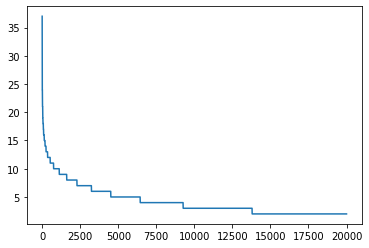

In [45]:
import matplotlib.pyplot as plt
%matplotlib inline

first_100_freqs = [freq for word, freq in freq_dict_sorted[:20000]]
plt.plot(first_100_freqs)
plt.show()

делю по частоте токена

In [46]:
high = freq_dict_sorted[:2500]
average = freq_dict_sorted[2500:10000]
low = freq_dict_sorted[10000:]

In [47]:
high_word = [ i[0] for i in high]
average_word = [ i[0] for i in average]
low_word = [ i[0] for i in low]

high_word_v = [ k for k,v in dict_res.items() if v in high_word]
average_word_v = [ k for k,v in dict_res.items() if v in average_word]
low_word_v = [ k for k,v in dict_res.items() if v in low_word]

In [48]:
print(high_word_v[0])
print(average_word_v[0])
print(low_word_v[0])

самое
школота
хоть


In [49]:
print(dict_res['самое'] in high_word)
print(dict_res['школота'] in average_word)
print(dict_res['хоть'] in low_word_v)

True
True
True


In [50]:
print(dict_res['хоть'] in high_word)

False


In [51]:
a = ['хоть', 'школота', 'но', 'поверь', 'нас', 'то', 'же', 'самое', 'общество', 'профилирующий', 'предмет', 'типа']
for i in a:
    print(i, dict_res[i] in low_word_v)

хоть True
школота False
но True
поверь True
нас False
то True
же True
самое False
общество False
профилирующий False
предмет False
типа False


создаю колонки с частой, средней и низкой частотой слова, вставляю слова не прошедшие лематизацию, но на основе отлиматизированных слов т.к. предметы, предмет, предметов  это все одно слово, поэтому подсчет был по корню слов

In [52]:
df['lemma_h'] = df.text_token.apply(lambda x: [i for i in [w for w in [h for h in x]] if i in high_word_v])

In [53]:
df['lemma_av'] = df.text_token.apply(lambda x: [i for i in [w for w in [h for h in x]] if i in average_word_v])

In [54]:
df['lemma_l'] = df.text_token.apply(lambda x: [i for i in [w for w in [h for h in x]] if i in low_word_v])

In [55]:
# df.to_pickle('df_new.pkl')

In [56]:
# df = pd.read_pickle('df_new.pkl')

In [57]:
df.head()

,text,label,text_token,text_lemma,lemma_h,lemma_av,lemma_l
0,хоть школота но поверь нас то же самое обществ...,positive,"[хоть, школота, но, поверь, нас, то, же, самое...","[{'хоть': 'хоть'}, {'школота': 'школот'}, {'но...","[самое, предмет, типа]","[школота, нас, общество]","[хоть, но, поверь, то, же, профилирующий]"
1,да все таки он немного похож на него но мой ма...,positive,"[да, все, таки, он, немного, похож, на, него, ...","[{'да': 'да'}, {'все': 'весь'}, {'таки': 'таки...","[все, похож, мой, мальчик, все, равно]","[он, него]","[да, таки, немного, на, но, лучше]"
2,ну ты идиотка испугалась за тебя,positive,"[ну, ты, идиотка, испугалась, за, тебя]","[{'ну': 'ну'}, {'ты': 'ты'}, {'идиотка': 'идио...",[испугалась],"[ты, идиотка, тебя]","[ну, за]"
3,кто то углу сидит погибает от голода мы ещ пор...,positive,"[кто, то, углу, сидит, погибает, от, голода, м...","[{'кто': 'кто'}, {'то': 'то'}, {'углу': 'угол'...","[углу, сидит, взяли, жрать, хотим]","[кто, погибает, голода, мы, порции]","[то, от, ещ, хотя, уже, так, не]"
4,вот что значит страшилка но блин посмотрев все...,positive,"[вот, что, значит, страшилка, но, блин, посмот...","[{'вот': 'вот'}, {'что': 'что'}, {'значит': 'з...","[посмотрев, все, части, ощущение, авторы, курили]","[что, значит, страшилка, блин, тебя, что, что]","[вот, но, создастся, то]"


## обучение на частых токенах


In [58]:
str_cols = ['lemma_h', 'lemma_av', 'lemma_l']

d = {k: ' '.join for k in str_cols}

df = df.agg(d).join(df.drop(str_cols, 1))

c:\program files\python37\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """


In [59]:
df.head()

,lemma_h,lemma_av,lemma_l,text,label,text_token,text_lemma
0,самое предмет типа,школота нас общество,хоть но поверь то же профилирующий,хоть школота но поверь нас то же самое обществ...,positive,"[хоть, школота, но, поверь, нас, то, же, самое...","[{'хоть': 'хоть'}, {'школота': 'школот'}, {'но..."
0,самое предмет типа,школота нас общество,хоть но поверь то же профилирующий,на работе был полный пиддес так каждое закрыти...,negative,"[на, работе, был, полный, пиддес, так, каждое,...","[{'на': 'на'}, {'работе': 'работа'}, {'был': '..."
0,работе был полный каждое месяца,закрытие свихнусь,на пиддес так же так,хоть школота но поверь нас то же самое обществ...,positive,"[хоть, школота, но, поверь, нас, то, же, самое...","[{'хоть': 'хоть'}, {'школота': 'школот'}, {'но..."
0,работе был полный каждое месяца,закрытие свихнусь,на пиддес так же так,на работе был полный пиддес так каждое закрыти...,negative,"[на, работе, был, полный, пиддес, так, каждое,...","[{'на': 'на'}, {'работе': 'работа'}, {'был': '..."
1,все похож мой мальчик все равно,он него,да таки немного на но лучше,да все таки он немного похож на него но мой ма...,positive,"[да, все, таки, он, немного, похож, на, него, ...","[{'да': 'да'}, {'все': 'весь'}, {'таки': 'таки..."


In [60]:
x_train, x_test, y_train, y_test = train_test_split(df.lemma_h, df.label)

In [61]:
vec = TfidfVectorizer(ngram_range=(1, 1))
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

c:\program files\python37\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


              precision    recall  f1-score   support

    negative       0.32      0.37      0.34     49341
    positive       0.45      0.40      0.43     63329

    accuracy                           0.39    112670
   macro avg       0.39      0.39      0.38    112670
weighted avg       0.39      0.39      0.39    112670



## на токенах средней частоты

In [62]:
x_train, x_test, y_train, y_test = train_test_split(df.lemma_av, df.label)

In [63]:
vec = TfidfVectorizer(ngram_range=(1, 1))
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

c:\program files\python37\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


              precision    recall  f1-score   support

    negative       0.24      0.34      0.28     39358
    positive       0.54      0.42      0.47     73312

    accuracy                           0.39    112670
   macro avg       0.39      0.38      0.38    112670
weighted avg       0.44      0.39      0.41    112670



## на токенах низкой частоты

In [64]:
x_train, x_test, y_train, y_test = train_test_split(df.lemma_l, df.label)

In [65]:
vec = TfidfVectorizer(ngram_range=(1, 1))
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

c:\program files\python37\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


              precision    recall  f1-score   support

    negative       0.21      0.28      0.24     43326
    positive       0.45      0.37      0.40     69344

    accuracy                           0.33    112670
   macro avg       0.33      0.32      0.32    112670
weighted avg       0.36      0.33      0.34    112670



я считаю токены с высокой частотой показали лучший результат в сравнении с другими

In [66]:
df.to_pickle('df_new.pkl')

# найти фичи с наибольшей значимостью, и вывести их

In [67]:
# df = pd.read_pickle('df_new.pkl')

In [68]:
df.head()

,lemma_h,lemma_av,lemma_l,text,label,text_token,text_lemma
0,самое предмет типа,школота нас общество,хоть но поверь то же профилирующий,хоть школота но поверь нас то же самое обществ...,positive,"[хоть, школота, но, поверь, нас, то, же, самое...","[{'хоть': 'хоть'}, {'школота': 'школот'}, {'но..."
0,самое предмет типа,школота нас общество,хоть но поверь то же профилирующий,на работе был полный пиддес так каждое закрыти...,negative,"[на, работе, был, полный, пиддес, так, каждое,...","[{'на': 'на'}, {'работе': 'работа'}, {'был': '..."
0,работе был полный каждое месяца,закрытие свихнусь,на пиддес так же так,хоть школота но поверь нас то же самое обществ...,positive,"[хоть, школота, но, поверь, нас, то, же, самое...","[{'хоть': 'хоть'}, {'школота': 'школот'}, {'но..."
0,работе был полный каждое месяца,закрытие свихнусь,на пиддес так же так,на работе был полный пиддес так каждое закрыти...,negative,"[на, работе, был, полный, пиддес, так, каждое,...","[{'на': 'на'}, {'работе': 'работа'}, {'был': '..."
1,все похож мой мальчик все равно,он него,да таки немного на но лучше,да все таки он немного похож на него но мой ма...,positive,"[да, все, таки, он, немного, похож, на, него, ...","[{'да': 'да'}, {'все': 'весь'}, {'таки': 'таки..."


In [69]:
from string import punctuation
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [70]:
from nltk.corpus import stopwords
# nltk.download('stopwords')
print(stopwords.words('russian'))

['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со', 'как', 'а', 'то', 'все', 'она', 'так', 'его', 'но', 'да', 'ты', 'к', 'у', 'же', 'вы', 'за', 'бы', 'по', 'только', 'ее', 'мне', 'было', 'вот', 'от', 'меня', 'еще', 'нет', 'о', 'из', 'ему', 'теперь', 'когда', 'даже', 'ну', 'вдруг', 'ли', 'если', 'уже', 'или', 'ни', 'быть', 'был', 'него', 'до', 'вас', 'нибудь', 'опять', 'уж', 'вам', 'ведь', 'там', 'потом', 'себя', 'ничего', 'ей', 'может', 'они', 'тут', 'где', 'есть', 'надо', 'ней', 'для', 'мы', 'тебя', 'их', 'чем', 'была', 'сам', 'чтоб', 'без', 'будто', 'чего', 'раз', 'тоже', 'себе', 'под', 'будет', 'ж', 'тогда', 'кто', 'этот', 'того', 'потому', 'этого', 'какой', 'совсем', 'ним', 'здесь', 'этом', 'один', 'почти', 'мой', 'тем', 'чтобы', 'нее', 'сейчас', 'были', 'куда', 'зачем', 'всех', 'никогда', 'можно', 'при', 'наконец', 'два', 'об', 'другой', 'хоть', 'после', 'над', 'больше', 'тот', 'через', 'эти', 'нас', 'про', 'всего', 'них', 'какая', 'много', 'разве', 'три', 'эту', 'моя', 'впр

In [71]:
noise = stopwords.words('russian') + list(punctuation)

удаляю стоп-слова и символы менее двух букв

In [73]:
df['not_st_w'] = df.text.apply(lambda x: [w for w in str(x).split() if w not in noise and len(w) >= 2])

In [74]:
df.shape

(450680, 8)

In [75]:
str_cols = ['not_st_w']

d = {k: ' '.join for k in str_cols}

df = df.agg(d).join(df.drop(str_cols, 1))

c:\program files\python37\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """


In [76]:
df.to_pickle('df_new.pkl')

In [77]:
# df = pd.read_pickle('df_new.pkl')

In [78]:
# df.head()

собираю все слова в один список

In [79]:
words = []
for w in df['not_st_w']:
    w = w.split()
    for i in w:
        words.append(i)

In [80]:
print(len(words))
len(set(words))


11378848


170955

In [81]:
# import gc
# gc.collect()

In [82]:
tfidf_vectorizer = TfidfVectorizer()
values = tfidf_vectorizer.fit_transform(df['not_st_w'])

# Show the Model as a pandas DataFrame
feature_names = tfidf_vectorizer.get_feature_names()


c:\program files\python37\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [83]:
words

['школота',
 'поверь',
 'самое',
 'общество',
 'профилирующий',
 'предмет',
 'типа',
 'школота',
 'поверь',
 'самое',
 'общество',
 'профилирующий',
 'предмет',
 'типа',
 'школота',
 'поверь',
 'самое',
 'общество',
 'профилирующий',
 'предмет',
 'типа',
 'школота',
 'поверь',
 'самое',
 'общество',
 'профилирующий',
 'предмет',
 'типа',
 'работе',
 'полный',
 'пиддес',
 'каждое',
 'закрытие',
 'месяца',
 'свихнусь',
 'работе',
 'полный',
 'пиддес',
 'каждое',
 'закрытие',
 'месяца',
 'свихнусь',
 'работе',
 'полный',
 'пиддес',
 'каждое',
 'закрытие',
 'месяца',
 'свихнусь',
 'работе',
 'полный',
 'пиддес',
 'каждое',
 'закрытие',
 'месяца',
 'свихнусь',
 'школота',
 'поверь',
 'самое',
 'общество',
 'профилирующий',
 'предмет',
 'типа',
 'школота',
 'поверь',
 'самое',
 'общество',
 'профилирующий',
 'предмет',
 'типа',
 'школота',
 'поверь',
 'самое',
 'общество',
 'профилирующий',
 'предмет',
 'типа',
 'школота',
 'поверь',
 'самое',
 'общество',
 'профилирующий',
 'предмет',
 'тип

In [85]:
value = values.data
column_index = values.indices
row_pointers = values.indptr

In [86]:
res = zip(value, words)

In [87]:
max_feature = [i for i in res]

In [88]:

print(len(max_feature))
print(len(set(max_feature)))
max_feature = set(max_feature)

11203216
9155948


собираю в список все слова с важностью более 0.9

In [89]:
max_f = [{j:i} for i, j in max_feature if i > 0.9]

In [90]:
print(len(max_f))
max_f

22674


[{'статус': 1.0},
 {'бля': 0.932169281060435},
 {'раша': 1.0},
 {'баскер': 0.9157858606515547},
 {'лермана': 0.9004557863358869},
 {'никита': 1.0},
 {'чимина': 1.0},
 {'счастья': 0.9001131880334203},
 {'это': 0.9039986510610902},
 {'обкидали': 1.0},
 {'фотографии': 1.0},
 {'тоха': 1.0},
 {'фляга': 1.0},
 {'аххахах': 1.0},
 {'каааждый': 0.9356249670602431},
 {'годе': 1.0},
 {'зимы': 0.9005393890383714},
 {'написать': 0.9401449102759764},
 {'тотали': 1.0},
 {'опухоль': 1.0},
 {'оскорбить': 0.9033866876988565},
 {'просишь': 1.0},
 {'скорбим': 0.929633441436747},
 {'рокеры': 1.0},
 {'хватало': 0.9037641820375514},
 {'брюнета': 1.0},
 {'мин': 0.9108192696410318},
 {'бюджет': 1.0},
 {'снежный': 0.9745772372338394},
 {'чате': 0.9336417704090451},
 {'ямайки': 1.0},
 {'анти': 1.0},
 {'передать': 1.0},
 {'спать': 0.9226123144763138},
 {'сша': 0.9583754118498293},
 {'буду': 0.9590750503795415},
 {'светлана': 1.0},
 {'почему': 0.9558794479323705},
 {'рада': 0.9459447921762486},
 {'ахахахах': 1.0},

# сравнить count/tf-idf/hashing векторайзеры/полносвязанную сетку (построить classification_report)

In [2]:
df = pd.read_pickle('df_new.pkl')

In [3]:
df.head()

,not_st_w,lemma_h,lemma_av,lemma_l,text,label,text_token,text_lemma
0,школота поверь самое общество профилирующий пр...,самое предмет типа,школота нас общество,хоть но поверь то же профилирующий,хоть школота но поверь нас то же самое обществ...,positive,"[хоть, школота, но, поверь, нас, то, же, самое...","[{'хоть': 'хоть'}, {'школота': 'школот'}, {'но..."
0,школота поверь самое общество профилирующий пр...,самое предмет типа,школота нас общество,хоть но поверь то же профилирующий,на работе был полный пиддес так каждое закрыти...,negative,"[на, работе, был, полный, пиддес, так, каждое,...","[{'на': 'на'}, {'работе': 'работа'}, {'был': '..."
0,школота поверь самое общество профилирующий пр...,работе был полный каждое месяца,закрытие свихнусь,на пиддес так же так,хоть школота но поверь нас то же самое обществ...,positive,"[хоть, школота, но, поверь, нас, то, же, самое...","[{'хоть': 'хоть'}, {'школота': 'школот'}, {'но..."
0,школота поверь самое общество профилирующий пр...,работе был полный каждое месяца,закрытие свихнусь,на пиддес так же так,на работе был полный пиддес так каждое закрыти...,negative,"[на, работе, был, полный, пиддес, так, каждое,...","[{'на': 'на'}, {'работе': 'работа'}, {'был': '..."
0,работе полный пиддес каждое закрытие месяца св...,самое предмет типа,школота нас общество,хоть но поверь то же профилирующий,хоть школота но поверь нас то же самое обществ...,positive,"[хоть, школота, но, поверь, нас, то, же, самое...","[{'хоть': 'хоть'}, {'школота': 'школот'}, {'но..."


In [12]:
x_train, x_test, y_train, y_test = train_test_split(df.not_st_w, df.label)

## tfidf

In [17]:
%%time
vec = TfidfVectorizer(ngram_range=(1, 1))
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

c:\program files\python37\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


              precision    recall  f1-score   support

    negative       0.36      0.36      0.36    219583
    positive       0.38      0.37      0.37    228856

    accuracy                           0.37    448439
   macro avg       0.37      0.37      0.37    448439
weighted avg       0.37      0.37      0.37    448439

Wall time: 48.9 s


## count_vectorizer

In [18]:
%%time
count_vectorizer = CountVectorizer(ngram_range=(1,1))
# vec = TfidfVectorizer(ngram_range=(1, 1))
bow = count_vectorizer.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(count_vectorizer.transform(x_test))
print(classification_report(pred, y_test))

c:\program files\python37\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


              precision    recall  f1-score   support

    negative       0.36      0.36      0.36    223665
    positive       0.37      0.37      0.37    224774

    accuracy                           0.37    448439
   macro avg       0.37      0.37      0.37    448439
weighted avg       0.37      0.37      0.37    448439

Wall time: 45 s


## hashing векторайзер


In [19]:
from sklearn.feature_extraction.text import HashingVectorizer

In [20]:
%%time
vectorizer = HashingVectorizer(n_features=2 ** 10)
# values = vectorizer.fit_transform(document)
# count_vectorizer = CountVectorizer(ngram_range=(1,1))
# vec = TfidfVectorizer(ngram_range=(1, 1))
bow = vectorizer.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vectorizer.transform(x_test))
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

    negative       0.43      0.48      0.45    198981
    positive       0.54      0.49      0.51    249458

    accuracy                           0.48    448439
   macro avg       0.48      0.48      0.48    448439
weighted avg       0.49      0.48      0.49    448439

Wall time: 32.2 s


Count Vectors может быть полезен для понимания типа текста по частоте слов в нем  
TF-IDF лучше, чем Count Vectorizers, потому что он не только фокусируется на частоте слов, присутствующих в корпусе, но и обеспечивает важность слов  
hashing векторайзер Не  хранит словарь токенов(полезно при работе с большими данными) поэтому работает быстрее, Недостатком этого является то, что невозможно будет получить фактический токен с учетом позиции столбца. Это было бы особенно важно в таких задачах, как извлечение ключевыхслов, где вы хотите получить и использовать фактические токены.

## NN

In [86]:
import tensorflow as tf

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D, Conv1D, GRU, LSTM, Dropout
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

from sklearn import model_selection, preprocessing, linear_model

In [87]:
trainDF = pd.read_pickle('df_new.pkl')

In [88]:
trainDF['not_st_w'] = trainDF['not_st_w'].apply(lambda x: str(x))


In [104]:
trainDF = trainDF.head(1000)

In [105]:
from sklearn import model_selection, preprocessing, linear_model

train_x, valid_x, train_y, valid_y = model_selection.train_test_split(trainDF['not_st_w'], trainDF['label'])

# labelEncode целевую переменную
encoder = preprocessing.LabelEncoder()
train_y = encoder.fit_transform(train_y)
valid_y = encoder.fit_transform(valid_y)


count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
count_vect.fit(trainDF['not_st_w'])

xtrain_count =  count_vect.transform(train_x)
xvalid_count =  count_vect.transform(valid_x)

classifier = linear_model.LogisticRegression()
classifier.fit(xtrain_count, train_y)
predictions = classifier.predict(xvalid_count)
predictions

array([0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0,
       1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0,
       1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0,
       1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1,
       1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1,
       1, 1, 1, 0, 0, 1, 0, 0])

In [106]:
from sklearn.metrics import accuracy_score

In [107]:
trainDF['label'].value_counts()

positive    500
negative    500
Name: label, dtype: int64

In [108]:
vct = HashingVectorizer(analyzer='word', token_pattern=r'\w{1,}', n_features=200)
vct.fit(trainDF['not_st_w'])

xtrain_hash =  vct.transform(train_x)
xvalid_hash =  vct.transform(valid_x)

classifier = linear_model.LogisticRegression()
classifier.fit(xtrain_hash, train_y)
predictions = classifier.predict(xvalid_hash)
predictions

array([0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0,
       1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0,
       0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1,
       0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0,
       1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0,
       1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1,
       1, 0, 1, 0, 0, 1, 0, 0])

In [109]:
train_data = tf.data.Dataset.from_tensor_slices((train_x, train_y))
valid_data = tf.data.Dataset.from_tensor_slices((valid_x, valid_y))

In [110]:
train_data = train_data.batch(256)
valid_data = valid_data.batch(256)

In [111]:
for raw in train_data.take(1):
    pass

In [112]:
raw

(<tf.Tensor: shape=(256,), dtype=string, numpy=
 array([b'\xd0\xbe\xd0\xb4\xd0\xbd\xd0\xbe\xd0\xbc\xd1\x83 \xd0\xbd\xd0\xb0\xd0\xbf\xd0\xbe\xd0\xbc\xd0\xb8\xd0\xbd\xd0\xb0\xd0\xb5\xd1\x82 \xd0\xb4\xd0\xbe\xd0\xbc \xd0\xbf\xd1\x83\xd1\x82\xd0\xb8\xd0\xbd \xd0\xb4\xd0\xb5\xd0\xbb\xd0\xb0\xd0\xb5\xd1\x82 \xd1\x80\xd0\xb5\xd0\xb0\xd0\xbb\xd0\xb8\xd1\x82\xd0\xb8 \xd1\x88\xd0\xbe\xd1\x83',
        b'\xd0\xbd\xd1\x80\xd0\xb0\xd0\xb2\xd1\x8f\xd1\x82\xd1\x81\xd1\x8f \xd0\xbc\xd1\x83\xd0\xb6\xd1\x87\xd0\xb8\xd0\xbd\xd1\x8b \xd1\x81\xd1\x82\xd1\x80\xd0\xbe\xd0\xb3\xd0\xb8\xd1\x85 \xd0\xba\xd0\xbe\xd1\x81\xd1\x82\xd1\x8e\xd0\xbc\xd0\xb0\xd1\x85 \xd0\xbc\xd0\xbb\xd0\xb5\xd1\x8e',
        b'\xd0\xb2\xd0\xbe\xd1\x81\xd0\xbf\xd0\xb0\xd0\xbb\xd0\xb5\xd0\xbd\xd0\xb8\xd0\xb5 \xd0\xbb\xd0\xb5\xd0\xb3\xd0\xba\xd0\xb8\xd1\x85 \xd0\xbd\xd0\xb5\xd0\xb4\xd0\xb5\xd0\xbb\xd0\xb8 \xd0\xb1\xd0\xbe\xd0\xbb\xd1\x8c\xd0\xbd\xd0\xb8\xd1\x86\xd0\xb5 \xd0\xbb\xd0\xb5\xd0\xb6\xd0\xb0\xd0\xbb\xd0\xb0 \xd1\x82\xd0\xb2\xd0\

In [113]:
s = '\xd0\xb2\xd0\xbc\xd0\xb5\xd1\x81\xd1\x82\xd0\xb5 \xd1\x81\xd1\x87\xd0\xb0\xd1\x81\xd1\x82\xd0\xbb\xd0\xb8\xd0\xb2\xd0\xbe\xd0\xb9 \xd0\xbf\xd0\xbb\xd0\xb0\xd0\xba\xd0\xb0\xd0\xbb\xd0\xb0'
decoded = bytes(s, encoding='latin').decode()
print(decoded)

вместе счастливой плакала


In [114]:
AUTOTUNE = tf.data.AUTOTUNE

train_data = train_data.cache().prefetch(buffer_size=AUTOTUNE)
valid_data = valid_data.cache().prefetch(buffer_size=AUTOTUNE)

In [115]:
def custom_standardization(input_data):
    
    return input_data

vocab_size = 10000
seq_len = 100

vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=seq_len)

# Make a text-only dataset (no labels) and call adapt to build the vocabulary.
text_data = train_data.map(lambda x, y: x)
vectorize_layer.adapt(text_data)

In [116]:
embedding_dim=200

10*100*200

model = Sequential([
    vectorize_layer,
    Embedding(vocab_size, embedding_dim),
    Conv1D(200, (3)),
    Conv1D(200, (2)),
    GRU(300),
    #GlobalAveragePooling1D(),
    Dense(100, activation='relu'),
    Dense(1)
])

In [117]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [118]:
model.fit(train_data, epochs=2)

Epoch 1/2
3/3 [==============================] - 6s 827ms/step - loss: 0.6947 - accuracy: 0.4907
Epoch 2/2
3/3 [==============================] - 2s 808ms/step - loss: 0.6979 - accuracy: 0.4907


In [ ]:
pred = model.predict(x_test)

In [127]:
pred = model.evaluate(valid_data)

1/1 [==============================] - 1s 1s/step - loss: 0.6950 - accuracy: 0.5280


In [129]:
pred = model.predict(x_test)

14014/14014 [==============================] - 1354s 97ms/step


нейро сеть недообучилась(видно по loss), данных мало, я уменьгил датасет до 1000 строк и всего одна эпоха на изначальном сеть очень долго обучается

конечно если NN дообучить на полных данных она покажет лучший результат, самое главное не переобучить